In [7]:
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 1115393 characters, 65 unique.


In [8]:
# lets try write here the LTSM version lol 
# hyperparameters
hidden_size = 512 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-2

In [9]:
# model parameters 
def init_weight(*shape):
    fan_in = shape[1] if len(shape) > 1 else shape[0]
    return np.random.randn(*shape) * np.sqrt(2.0 / fan_in)  # He initialization

def init_weight_orthogonal(*shape, gain=1.0):
    W = np.random.randn(*shape)
    u, _, v = np.linalg.svd(W, full_matrices=False)
    W = u if u.shape == shape else v.T  # Handle non-square
    return gain * W  # Scale for activation functions (e.g., ReLU: gain=√2)


triple = lambda: (init_weight(hidden_size, vocab_size), # input to hidden
                init_weight_orthogonal(hidden_size, hidden_size), # hidden to hidden
                np.zeros((hidden_size, 1))) #hidden bias
Wxi, Whi, bi = triple()  # Input gate
Wxf, Whf, bf = triple()  # Forget gate
Wxo, Who, bo = triple()  # Output gate
Wxc, Whc, bc = triple()  # Input node

Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
by = np.zeros((vocab_size, 1)) #output bias 

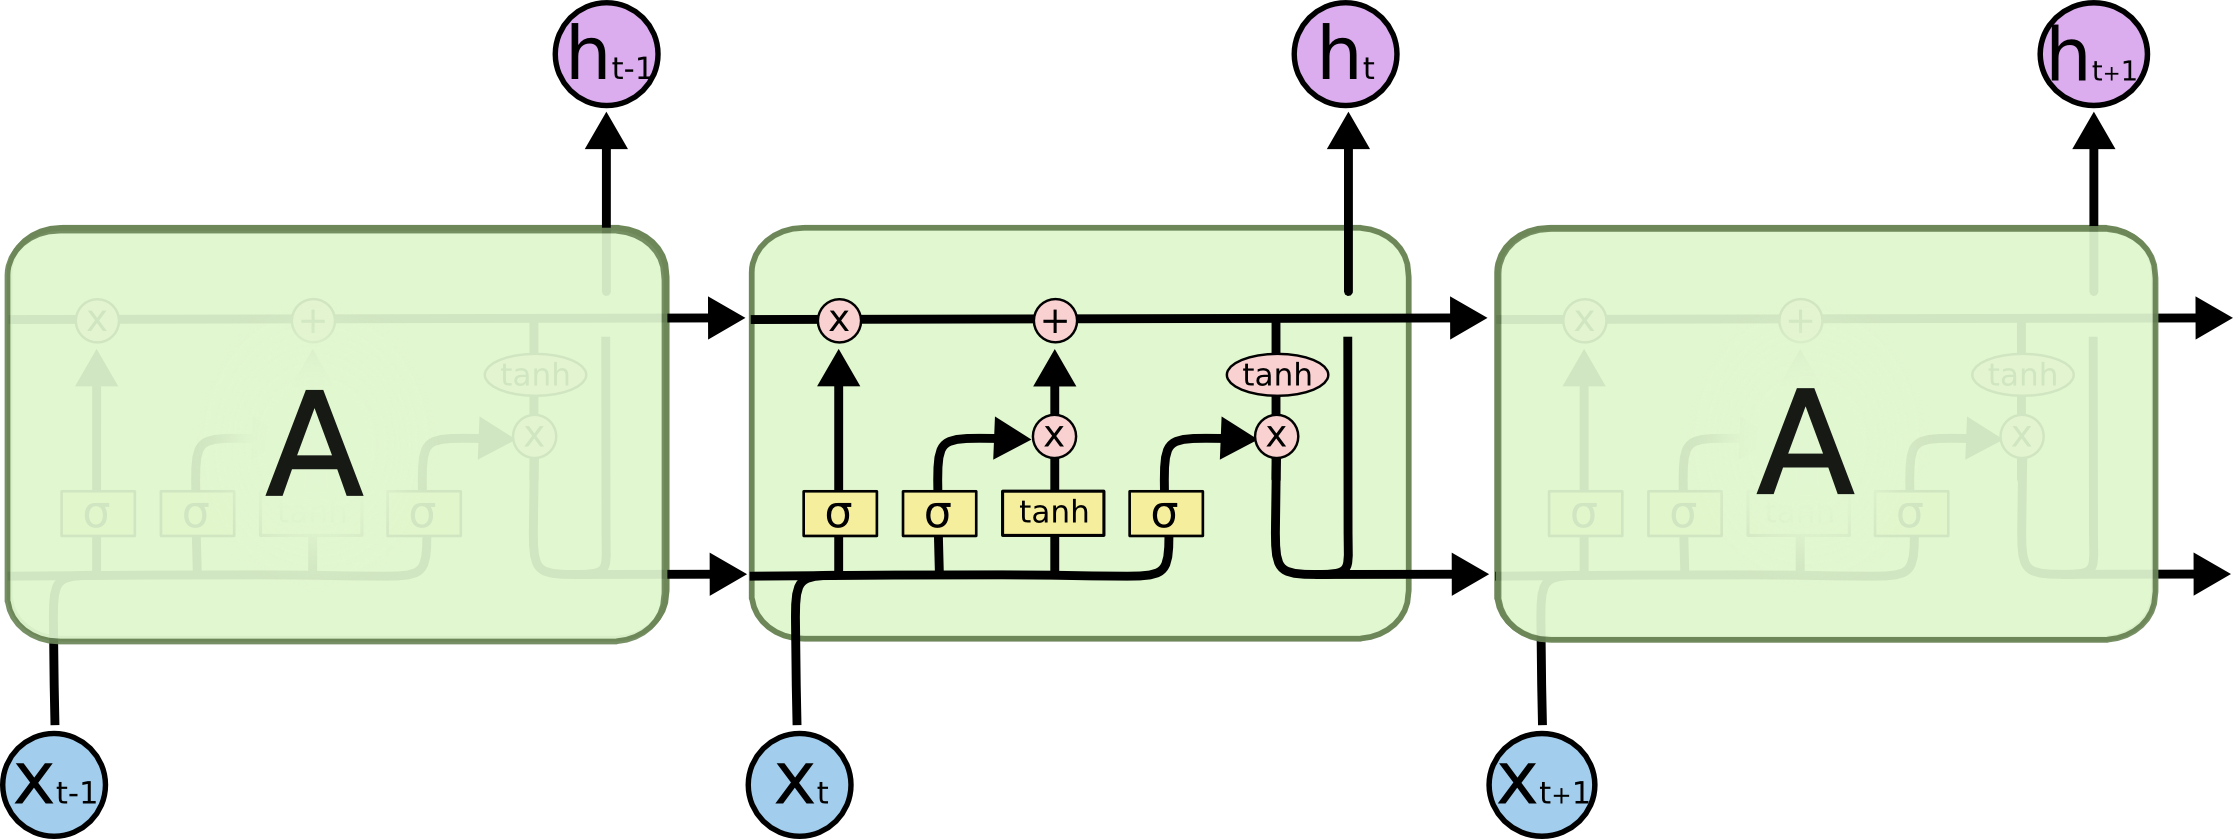
![Screenshot 2025-01-21 at 22.01.08.png](<attachment:Screenshot 2025-01-21 at 22.01.08.png>)
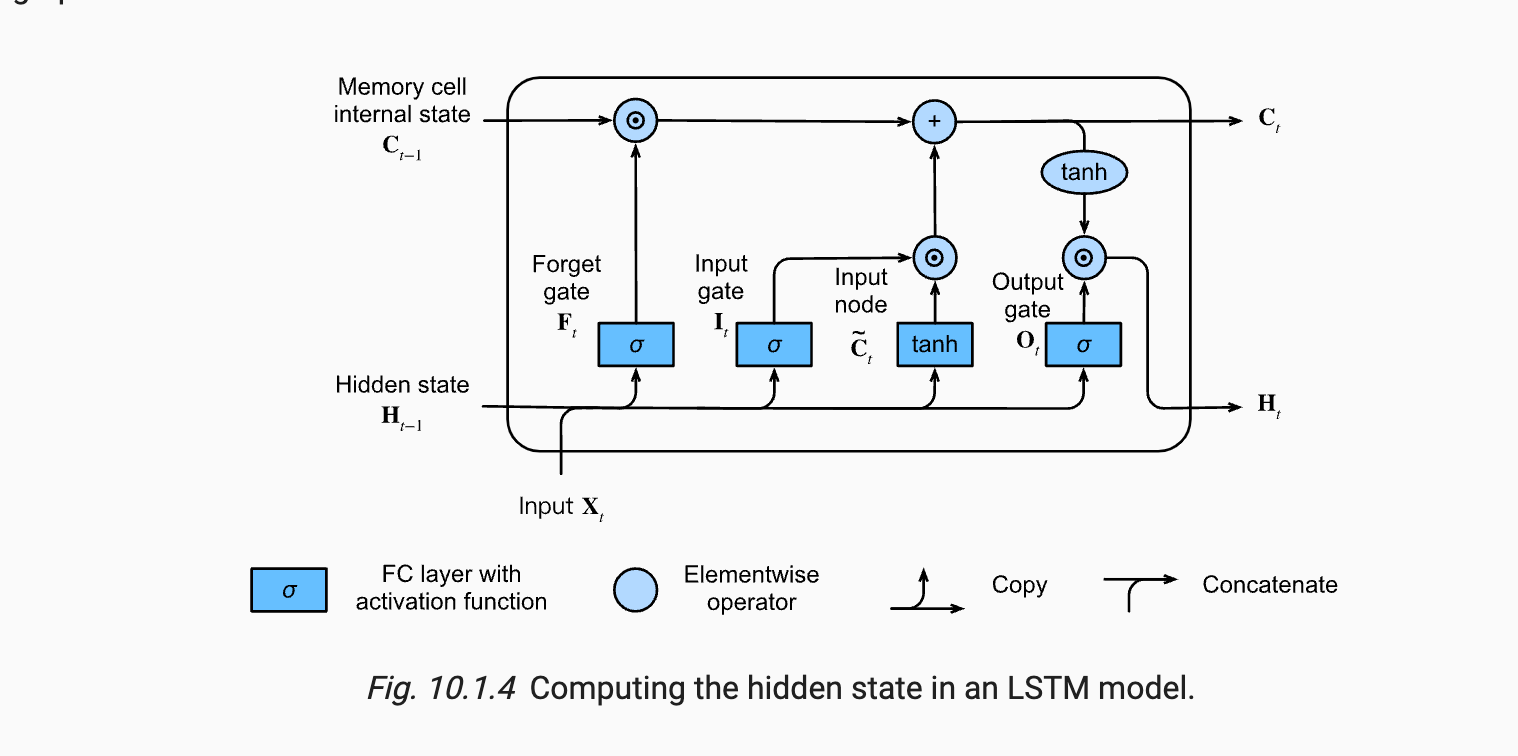

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 

def softmax(input):
    # Subtraction of max value improves numerical stability.
    e_input = np.exp(input - np.max(input))
    return e_input / e_input.sum()

def lossFunLTSM(inputs, targets, hprev, cprev):
    """
        inputs, targets are both list of integers.
        hprev is Hx1 array of initial hidden state  
        cprev is Hx1 array of initial cell state
        returns the loss, gradients on model parameters, and last hidden and cell state
    """
    xs, hs, cs, ys, ps, i_s, f_s, o_s, c_tildes = {}, {}, {}, {}, {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    cs[-1] = np.copy(cprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1

        #LTSM forward pass
        i_s[t] = sigmoid(np.dot(Wxi, xs[t]) + np.dot(Whi, hs[t-1]) + bi) # (hidden,1)
        f_s[t] = sigmoid(np.dot(Wxf, xs[t]) + np.dot(Whf, hs[t-1]) + bf) # (hidden, 1)
        o_s[t] = sigmoid(np.dot(Wxo, xs[t]) + np.dot(Who, hs[t-1]) + bo) # (hidden, 1)
        c_tildes[t] = np.tanh(np.dot(Wxc, xs[t]) + np.dot(Whc, hs[t-1]) + bc) # (hidden, 1)

        cs[t] = f_s[t] * cs[t-1] + i_s[t] * c_tildes[t] # memory cell, internal state elementwise multiply (hidden, 1)
        hs[t] = o_s[t] * np.tanh(cs[t]) # hidden state, elementwise multiply (hidden, 1)

        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars (vocab, 1)
        ps[t] = softmax(ys[t])  # probabilities for next chars
        loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)
    
  
    # backward pass: compute gradients going backwards
    dWxi, dWhi, dbi = np.zeros_like(Wxi), np.zeros_like(Whi), np.zeros_like(bi)
    dWxf, dWhf, dbf = np.zeros_like(Wxf), np.zeros_like(Whf), np.zeros_like(bf)
    dWxo, dWho, dbo = np.zeros_like(Wxo), np.zeros_like(Who), np.zeros_like(bo)
    dWxc, dWhc, dbc = np.zeros_like(Wxc), np.zeros_like(Whc), np.zeros_like(bc)
    dWhy, dby = np.zeros_like(Why), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    dcnext = np.zeros_like(cs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  # backprop into y
        dWhy += np.dot(dy, hs[t].T)
        dby += dy

        dh = np.dot(Why.T, dy) + dhnext  # backprop into h
        do = dh * np.tanh(cs[t])
        do = do * o_s[t] * (1 - o_s[t]) # backprop through output gate # if do = do * sigmoid'(o)

        dc = dh * o_s[t] * (1 - np.tanh(cs[t]) ** 2) + dcnext # backprop through cell state
        di = dc * c_tildes[t]
        di = di * i_s[t] * (1 - i_s[t]) # backprop through input gate sigmoid' = sigmoid * (1 - sigmoid)
        df = dc * cs[t-1]
        df = df * f_s[t] * (1 - f_s[t])  # backprop through forget gate
        dc_tilde = dc * i_s[t]
        dc_tilde = dc_tilde * (1 - c_tildes[t] ** 2) # backprop through input node

        # accumulate gradients for weights and biases
        dWxi += np.dot(di, xs[t].T)
        dWhi += np.dot(di, hs[t-1].T)
        dbi += di

        dWxf += np.dot(df, xs[t].T)
        dWhf += np.dot(df, hs[t-1].T)
        dbf += df

        dWxo += np.dot(do, xs[t].T)
        dWho += np.dot(do, hs[t-1].T)
        dbo += do

        dWxc += np.dot(dc_tilde, xs[t].T)
        dWhc += np.dot(dc_tilde, hs[t-1].T)
        dbc += dc_tilde

        # pass gradients to the next time step
        dhnext = np.dot(Whi.T, di) + np.dot(Whf.T, df) + np.dot(Who.T, do) + np.dot(Whc.T, dc_tilde)
        dcnext = dc * f_s[t]

    return loss, dWxi, dWhi, dbi, dWxf, dWhf, dbf, dWxo, dWho, dbo, dWxc, dWhc, dbc, dWhy, dby, hs[len(inputs)-1], cs[len(inputs)-1]

In [11]:
def sampleLTSM(h, c, seed_ix, n):
    """ 
    Sample a sequence of integers from the model 
    h is the hidden state, c is the cell state, seed_ix is the seed letter for the first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        # LSTM forward pass for one time step
        i = sigmoid(np.dot(Wxi, x) + np.dot(Whi, h) + bi)
        f = sigmoid(np.dot(Wxf, x) + np.dot(Whf, h) + bf)
        o = sigmoid(np.dot(Wxo, x) + np.dot(Who, h) + bo)
        c_tilde = np.tanh(np.dot(Wxc, x) + np.dot(Whc, h) + bc)
        c = f * c + i * c_tilde
        h = o * np.tanh(c)

        y = np.dot(Why, h) + by
        p = softmax(y)
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [ ]:
# Memory variables for Adagrad
mWxi, mWhi, mbi = np.zeros_like(Wxi), np.zeros_like(Whi), np.zeros_like(bi)
mWxf, mWhf, mbf = np.zeros_like(Wxf), np.zeros_like(Whf), np.zeros_like(bf)
mWxo, mWho, mbo = np.zeros_like(Wxo), np.zeros_like(Who), np.zeros_like(bo)
mWxc, mWhc, mbc = np.zeros_like(Wxc), np.zeros_like(Whc), np.zeros_like(bc)
mWhy, mby = np.zeros_like(Why), np.zeros_like(by) # memory variables for Adagrad

# Loss at iteration 0
smooth_loss = -np.log(1.0/vocab_size)*seq_length 

n, p = 0, 0
while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1))  # reset RNN memory
        cprev = np.zeros((hidden_size, 1))  # reset cell state
        p = 0 # go from start of data
        
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length + 1]]

    #sample from the model now and then 
    if n % 100 == 0:
        sample_ix = sampleLTSM(hprev, cprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, )) 
    
    # Forward seq_length characters through the net and fetch gradient
    loss, dWxi, dWhi, dbi, dWxf, dWhf, dbf, dWxo, dWho, dbo, dWxc, dWhc, dbc, dWhy, dby, hprev, cprev = lossFunLTSM(inputs, targets, hprev, cprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # Perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxi, Whi, bi, Wxf, Whf, bf, Wxo, Who, bo, Wxc, Whc, bc, Why, by],
                                  [dWxi, dWhi, dbi, dWxf, dWhf, dbf, dWxo, dWho, dbo, dWxc, dWhc, dbc, dWhy, dby],
                                  [mWxi, mWhi, mbi, mWxf, mWhf, mbf, mWxo, mWho, mbo, mWxc, mWhc, mbc, mWhy, mby]):
        np.clip(dparam, -5, 5, out=dparam)  # clip to mitigate exploding gradients
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # Adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

    if n == 44700 * 5: # 5 times pass the full text 
        break

----
 $gJx'X&B:GX$oDM-XOQc&
djKj$XNF;WCKZDn.HA-Fo&pCzb'DW hr&l;GAyjLyv:GE&$ErVYldZTPWf
udGYCDJJsNcOj,KsnHTMzNamMDnETbAqhF&mTN$YN;X,XteZZdO!dlCghFHV&BbSFUbAkaTpP?U$I&IED?Z&uQiwi3gM!hPuJ?wsO!T.FJoqA
kcqkhZPUl 
----
iter 0, loss: 104.359701
----
  e voher we,
ndkrat hesh wotewi
:oe h hpwh  hoyzenr
i h
pr iaew' 
ndea
 
oyml sh tote ekuykw:e houy hahotom anee een:h, hoFg hc uaa', olswt doree
hhtyeho C tos ctyo  iioz;Fhrunhnt dia ehel eer Cw tsn. 
----
iter 100, loss: 101.884615
----
 iri YCe, che oueMnnt EmltiSntiMnthe -hea
ser!n, the oog
 Ce
Sgi
oll'

lmtm.eden,imoWm lsptyrt halythve?osth
eslr lhl,
chooee
kCd Otl nore aou aay ahyaboetheiAoWtian  oileeWin weitiunt!e sa yhee:nd the 
----
iter 200, loss: 98.895890
----
 eang thYur aoReny-WT yeule;
Wo?l
Fh g movr uhes. wo thocg nm alven

hFg nolt toel
no ar ionavou
:
Wha g ior cor? fol.
TSe woa,yss,-geiaouhg youpMnN; Ii causs, CFaa:g;mio  irise Ov bingvond Iami, cour  
----
iter 300, loss: 95.828198
----
 nS banlust r they wicis  sopv
 o'le wa

### THEORY OFFTOPIC



Below is a **step-by-step** explanation of the math behind **backpropagation** in the LSTM snippet you provided. We’ll walk through each gate (input, forget, output, candidate cell state), how the hidden/cell states update, and finally how we accumulate gradients by going backward in time.

---

## 1. Forward Pass Recap

In your forward pass, at each time step $ t $:

1. **One-hot input**:  
   $$
   x_s[t] \in \mathbb{R}^{\text{vocab\_size}\times 1}.
   $$
   You also have a hidden state $ h_s[t-1] $ and cell state $ c_s[t-1] $.

2. **Gates** (all dimension $\text{hidden} \times 1$):

   - **Input Gate**:  
     $$
     i_t = \sigma(W_{xi} \, x_s[t] + W_{hi}\, h_s[t-1] + b_i).
     $$
   - **Forget Gate**:  
     $$
     f_t = \sigma(W_{xf} \, x_s[t] + W_{hf} \, h_s[t-1] + b_f).
     $$
   - **Output Gate**:  
     $$
     o_t = \sigma(W_{xo} \, x_s[t] + W_{ho} \, h_s[t-1] + b_o).
     $$
   - **Candidate Cell** ($ \tilde{c}_t $):  
     $$
     \tilde{c}_t = \tanh(W_{xc} \, x_s[t] + W_{hc}\, h_s[t-1] + b_c).
     $$

3. **Cell State Update**:  
   $$
   c_s[t] = f_t \odot c_s[t-1] \;+\; i_t \odot \tilde{c}_t.
   $$
   ($\odot$ = elementwise multiply)

4. **Hidden State Update**:  
   $$
   h_s[t] = o_t \odot \tanh(c_s[t]).
   $$

5. **Output (logits)**:  
   $$
   y_s[t] = W_{hy}\, h_s[t] + b_y,
   $$
   then probabilities via softmax $ p_s[t] = \mathrm{softmax}(y_s[t]) $.

6. **Loss** (cross-entropy):  
   $$
   \text{loss} = -\sum_{t} \log(p_s[t]_{(\text{target}[t])}).
   $$

---

## 2. Backprop Through Output Layer

### 2.1. Gradient wrt. $ y_s[t] $

**Softmax with cross-entropy** gives the typical “logits” gradient:

$$
\frac{\partial \text{loss}}{\partial y_s[t]} 
= p_s[t] - \mathbf{1}\{\text{target}[t]\}.
$$
In your code:

```python
dy = np.copy(ps[t])
dy[targets[t]] -= 1
```
This array `dy` is $\partial L / \partial y_s[t]$.

### 2.2. Hidden State to Output Weight

Then:
$$
dWhy \;+=\; dy \; h_s[t]^T,
\quad
dby \;+=\; dy.
$$
Because:
$$
\frac{\partial L}{\partial W_{hy}} 
= \frac{\partial L}{\partial y_s[t]} \cdot \frac{\partial y_s[t]}{\partial W_{hy}}
= dy \, (h_s[t])^T.
$$
$$
\frac{\partial L}{\partial b_y} 
= dy.
$$

### 2.3. Backprop into hidden state

$$
dh_t = W_{hy}^T \, dy \;+\; dh_{\text{next}}.
$$
In your code:
```python
dh = np.dot(Why.T, dy) + dhnext
```
Because you have to add any gradient coming from future timesteps $(dh_{\text{next}})$.

---

## 3. Backprop Through LSTM Cell (Single Timestep)

Let’s see how to get $\partial L/\partial h_s[t-1]$ and $\partial L/\partial c_s[t-1]$ from $\partial L/\partial h_s[t]$ and $\partial L/\partial c_s[t]$. We do this for each gate: input, forget, output, plus candidate cell.

### 3.1. Decompose $\partial L/\partial h_s[t]$

We had:

```python
dh = np.dot(Why.T, dy) + dhnext
```
Now we break that into partial derivatives for the gates. The hidden state is:
$$
h_s[t] = o_t \odot \tanh(c_s[t]).
$$
So:

$$
dh_s[t] = dh.
$$
We define:
$$
do_t = dh \odot \tanh(c_s[t])
\quad
\text{and}
\quad
d(\tanh(c_s[t])) = dh \odot o_t
$$

But more explicitly, since:
$$
h_s[t] = o_t \odot \tanh(c_s[t]),
$$
$$
\frac{\partial h_s[t]}{\partial o_t} = \tanh(c_s[t]),
$$
$$
\frac{\partial h_s[t]}{\partial c_s[t]} = o_t \cdot (1-\tanh^2(c_s[t])).
$$

Hence:

1. $\displaystyle do = dh \odot \tanh(c_s[t])$.
2. $\displaystyle dc_s[t] = dh \odot o_t \odot (1 - \tanh^2(c_s[t]))$.

In your code:

```python
do = dh * np.tanh(cs[t])
do = do * o * (1 - o)  # if do = do * sigmoid'(o)
```
But wait, that second line is actually the derivative of the output gate **sigmoid**. So we have a chain rule:

$$
do \;=\; do \;\times\; \sigma'(o_t).
$$
where $\sigma'(z) = z(1 - z)$ for the sigmoid gate. That’s the line:

```python
do = do * o * (1 - o)
```
**(Which is** $\partial o_t / \partial (pre\_act\_o)$**).**

### 3.2. Cell State Derivatives

**Now** we have partial derivative w.r.t. $ c_s[t] $:
```python
dc = dh * o * (1 - np.tanh(cs[t])**2) + dcnext
```
This is effectively:
$$
dc_s[t] = \frac{\partial L}{\partial c_s[t]} = dh \odot o_t \odot (1-\tanh^2(c_s[t])) + dc_{\text{next}}.
$$
- The first part is from the direct chain of $\partial h_s[t]/ \partial c_s[t]$.
- We also add in $\partial L/\partial c_s[t]$ from the next time step, $dc_{\text{next}}$. Because the cell state c[t] also flows to c[t+1].

### 3.3. Input, Forget gates, and Candidate

Recall:

$$
c_s[t] = f_t \odot c_s[t-1] + i_t \odot \tilde{c}_t.
$$

Hence:

- $\partial c_s[t]/\partial f_t = c_s[t-1]$.
- $\partial c_s[t]/\partial i_t = \tilde{c}_t$.
- $\partial c_s[t]/\partial \tilde{c}_t = i_t$.

**Inside code**:

1. We have a variable `dc`, which is the total gradient wrt. `c_s[t]`.
2. So:
   ```python
   di = dc * c_tilde
   df = dc * cs[t-1]
   dc_tilde = dc * i
   ```
   Then we apply the gate activation derivatives:

   - For the input gate: `i = sigmoid(...)`, so $\partial i/\partial z = i(1-i)$.
     ```python
     di = di * i * (1 - i)
     ```
   - For the forget gate: `f = sigmoid(...)`.
     ```python
     df = df * f * (1 - f)
     ```
   - For candidate cell: `c_tilde = tanh(...)`.
     ```python
     dc_tilde = dc_tilde * (1 - c_tilde**2)
     ```

### 3.4. Summaries of Gate Derivatives

So we get partial derivatives:

$$
\frac{\partial L}{\partial (pre\_act\_i)} = di,\quad
\frac{\partial L}{\partial (pre\_act\_f)} = df,\quad
\frac{\partial L}{\partial (pre\_act\_o)} = do,\quad
\frac{\partial L}{\partial (pre\_act\_c\_tilde)} = dc\_tilde.
$$

---

## 4. Accumulate Weight/Bias Gradients

Each gate has parameters $(W_{x\_gate}, W_{h\_gate}, b_{\_gate})$. For example, the input gate uses `Wxi`, `Whi`, `bi`. We do:

```python
dWxi += np.dot(di, xs[t].T)
dWhi += np.dot(di, hs[t-1].T)
dbi   += di
```
This follows from:

$$
\frac{\partial L}{\partial W_{xi}} 
= \sum_t \frac{\partial L}{\partial (pre\_act\_i)} \,\cdot\, x_s[t]^T
$$
since `(pre_act_i) = W_{xi} * x_s[t] + W_{hi} * h_s[t-1] + b_i`.

Similarly for `f, o, c_tilde` gates.

### 4.1. Pass Gradients Back for Next Timestep

After we compute gate derivatives at time $ t$, we have:

$$
dh_{\text{next}} = \frac{\partial L}{\partial h_s[t-1]}
$$
$$
dc_{\text{next}} = \frac{\partial L}{\partial c_s[t-1]}
$$
so the code sets:

```python
dhnext = np.dot(Whi.T, di) + np.dot(Whf.T, df) + ...
dcnext = dc * f
```
Why? Because

$$
\frac{\partial L}{\partial h_s[t-1]}
= \sum_{g \in \{i,f,o,c\_tilde\}} W_{hg}^T \; \frac{\partial L}{\partial (pre\_act\_g)}
$$
plus any contributions from other paths if relevant. And for the cell state:

$$
\frac{\partial L}{\partial c_s[t-1]}
= \frac{\partial L}{\partial c_s[t]} \odot f_t.
$$

Hence:

```python
dhnext = np.dot(Whi.T, di) + np.dot(Whf.T, df) + ...
dcnext = dc * f
```

---

## 5. Clipping the Gradients

At the end,

```python
for dparam in [...]:
    np.clip(dparam, -5, 5, out=dparam)
```
**just** ensures each gradient stays in $[-5, 5]$ range to mitigate exploding gradients in RNNs. This doesn’t affect the chain rule itself; it’s a practical measure.

---

### **In Summary**

1. **Forward**: LSTM gates = $\sigma$ or $\tanh$. Hidden/cell update equations. Output log probabilities.  
2. **Backward**:
   - Start from the output layer error $\Delta y_s[t]$. Accumulate into `Why`, `by`.  
   - Propagate into hidden state $\Delta h_s[t]$.  
   - Break $\Delta h_s[t]$ into partial derivatives for output gate, cell state.  
   - Then $\Delta c_s[t]$ is combined with `dcnext` from the next step.  
   - Compute input gate, forget gate, candidate cell partials.  
   - Each gate’s gradient flows to the corresponding weight matrix.  
   - Compute $\Delta h_s[t-1]$ and $\Delta c_s[t-1]$ for the next iteration.  
3. **Clip** the final gradients to avoid exploding.  

This chain rule ensures each parameter of each gate receives the correct partial derivative.